### **Разработка системы анализа медицинских изображений для эпидемиологического мониторинга COVID-19**

#### **Цель проекта**
Разработать аналитическую систему для эпидемиологического мониторинга COVID-19 на основе метаданных рентгеновских снимков, используя стек PySpark.

___
### 1. Подготовка среды
- Установить PySpark.
- Настроить рабочее окружение.
- Проверить работу Spark в Jupyter Notebook.

Устанавливаем  pyspark

In [3]:
conda install -c conda-forge openjdk=17 pyspark

2 channel Terms of Service accepted
Channels:
 - conda-forge
 - defaults
Platform: osx-64
Solving environment: done

## Package Plan ##

  environment location: /Users/kvt/miniconda3/envs/new_big_data

  added / updated specs:
    - openjdk=17
    - pyspark


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openjdk-17.0.14            |       h46256e1_0       192.4 MB
    ------------------------------------------------------------
                                           Total:       192.4 MB

The following NEW packages will be INSTALLED:

  arrow-cpp          pkgs/main/osx-64::arrow-cpp-19.0.0-hb704434_4 
  aws-c-auth         conda-forge/osx-64::aws-c-auth-0.9.0-h11bee3c_15 
  aws-c-cal          conda-forge/osx-64::aws-c-cal-0.9.2-h80a239a_0 
  aws-c-common       conda-forge/osx-64::aws-c-common-0.12.3-h6e16a3a_0 
  aws-c-compression  conda-forge/osx-64::aws-c-compression-0.3.1-hdea44a

Проверим работу Spark в Jupyter Notebook

In [16]:
!java -version

openjdk version "17.0.14" 2025-01-21
OpenJDK Runtime Environment JBR-17.0.14+1-1367.22-nomod (build 17.0.14+1-b1367.22)
OpenJDK 64-Bit Server VM JBR-17.0.14+1-1367.22-nomod (build 17.0.14+1-b1367.22, mixed mode, sharing)


In [17]:
!python --version

Python 3.11.13


In [13]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.version

'4.0.1'

In [18]:
spark

___
##### Импорт необходимых библиотек

In [455]:
from pyspark.sql.types import  StringType, DateType

from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from pyspark.sql.functions import col, mean, when, col, rand, sum, desc, udf
import seaborn as sns

___
***Примечание: поменял местами пункты сначала Анализ качества данных, затем Предобработка***
### 3. Анализ качества данных
- Построить распределение пропущенных значений по всем полям.
- Выявить и обработать аномальные значения.
- Задокументировать обнаруженные проблемы данных.

*Считаем данные*

Берем поля по заданию:
- `patientid` (идентификатор пациента)
- `age` (возраст, есть не для всех записей)
- `sex` (пол, не для всех записей)
- `finding` (диагноз: COVID-19, Pneumonia, Normal и другие)
- `view` (проекция снимка: PA, AP и так далее)
- `date` (дата исследования)

In [456]:
spark = SparkSession.builder.appName("CovidInfo").getOrCreate()

df = spark.read.csv("metadata.csv", header=True, inferSchema=True).select("patientid", "age", "sex", "finding", "view", "date")

df.show(10)

+---------+----+----+--------------------+----+----------------+
|patientid| age| sex|             finding|view|            date|
+---------+----+----+--------------------+----+----------------+
|        2|  65|   M|Pneumonia/Viral/C...|  PA|January 22, 2020|
|        2|  65|   M|Pneumonia/Viral/C...|  PA|January 25, 2020|
|        2|  65|   M|Pneumonia/Viral/C...|  PA|January 27, 2020|
|        2|  65|   M|Pneumonia/Viral/C...|  PA|January 28, 2020|
|        4|  52|   F|Pneumonia/Viral/C...|  PA|January 25, 2020|
|        4|  52|   F|Pneumonia/Viral/C...|  PA|January 30, 2020|
|        5|NULL|NULL|           Pneumonia|  PA|            2017|
|        6|NULL|NULL|Pneumonia/Viral/C...|  PA| January 6, 2020|
|        6|NULL|NULL|Pneumonia/Viral/C...|  PA|January 10, 2020|
|        3|  74|   M|Pneumonia/Viral/SARS|  AP|            2004|
+---------+----+----+--------------------+----+----------------+
only showing top 10 rows


In [457]:
df.printSchema()

root
 |-- patientid: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- finding: string (nullable = true)
 |-- view: string (nullable = true)
 |-- date: string (nullable = true)



In [458]:
df.describe().show()

+-------+------------------+------------------+----+----------+----+------------------+
|summary|         patientid|               age| sex|   finding|view|              date|
+-------+------------------+------------------+----+----------+----+------------------+
|  count|               950|               713| 870|       950| 950|               661|
|   mean|244.10386740331492|  53.5343618513324|NULL|      NULL|NULL|2018.8994515539305|
| stddev|141.27667042618208|16.949006804228343|NULL|      NULL|NULL|2.9462429777605084|
|    min|                10|                18|   F|No Finding|  AP|          01/13/20|
|    max|                99|                94|   M|      todo|  PA|September 21, 2009|
+-------+------------------+------------------+----+----------+----+------------------+



Выводы по данным:

1. 
    - Возраст есть только в 713 записях.
    - Пол — в 870.
    - Дата — всего в 661.
2. Значения возраста 18 до 94 лет, среднее около 53 лет:
    - Наблюдаемый максимальный возраст 94 года реалистичен.
    - Минимум 18 лет также валиден (выборка взрослых).
    Поэтому считаю что в данной категории аномалий нет.
3. Дату необходимо перевести в DateTime

Строим распределение пропущенных значений по всем полям.

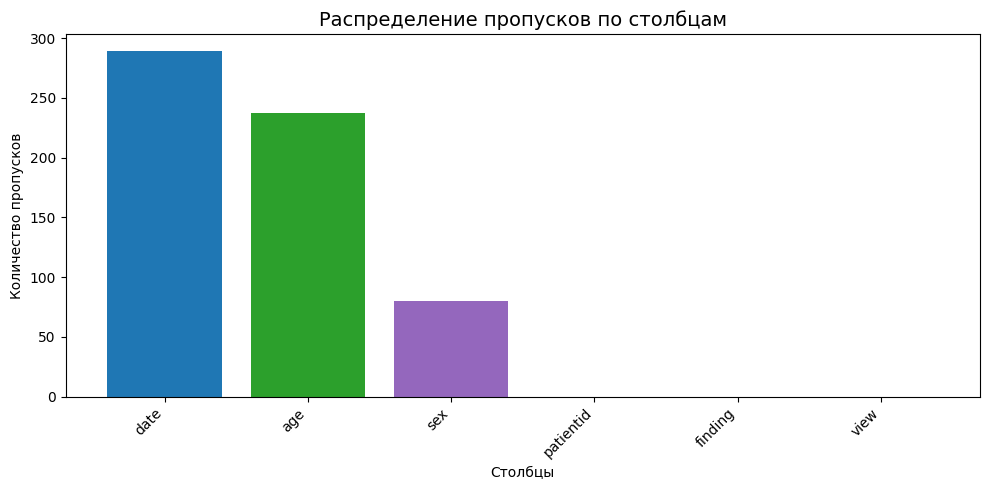

In [459]:
# считаем количество пропусков по каждому столбцу
null_df = df.select([sum(col(c).isNull().cast("int")).alias(c)
                    for c in df.columns])

# преобразуем в pandas
null_pd = null_df.toPandas().T
null_pd.columns = ["missing"]
null_pd = null_pd.sort_values("missing", ascending=False)

# строим график
plt.figure(figsize=(10, 5))

# используем цветовую карту для автоматической раскраски
colors = plt.cm.tab20(np.linspace(0, 1, len(null_pd)))

plt.bar(null_pd.index, null_pd["missing"], color=colors)

plt.title("Распределение пропусков по столбцам", fontsize=14)
plt.ylabel("Количество пропусков")
plt.xlabel("Столбцы")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

Разберем значения в текстовых данных:

In [460]:
df.select("finding").distinct().show(100, truncate=False)

+---------------------------------------+
|finding                                |
+---------------------------------------+
|Pneumonia/Bacterial/Streptococcus      |
|Pneumonia/Aspiration                   |
|Pneumonia/Lipoid                       |
|Tuberculosis                           |
|Pneumonia/Fungal/Pneumocystis          |
|Pneumonia/Bacterial/Klebsiella         |
|Pneumonia/Bacterial                    |
|Pneumonia/Viral/MERS-CoV               |
|Unknown                                |
|Pneumonia/Viral/Varicella              |
|Pneumonia/Bacterial/Staphylococcus/MRSA|
|Pneumonia/Viral/Influenza/H1N1         |
|Pneumonia/Bacterial/Nocardia           |
|todo                                   |
|Pneumonia/Bacterial/Mycoplasma         |
|Pneumonia/Viral/Influenza              |
|Pneumonia/Viral/COVID-19               |
|Pneumonia/Viral/SARS                   |
|Pneumonia/Bacterial/Legionella         |
|Pneumonia/Fungal/Aspergillosis         |
|Pneumonia/Viral/Herpes           

В целом аномалий не вижу, можно обьединить значения Unknown, todo, No Finding  в просто Unknown

In [461]:
df.select("sex").distinct().show(100, truncate=False)

+----+
|sex |
+----+
|F   |
|M   |
|NULL|
+----+



Аномалий нет, только пропуски.

In [462]:
df.select("view").distinct().show(100, truncate=False)

+---------+
|view     |
+---------+
|Axial    |
|Coronal  |
|L        |
|AP Supine|
|AP Erect |
|PA       |
|AP       |
+---------+



Аномалий нет.

Перейдем к дате.

In [463]:
df.select("date") \
  .distinct() \
  .orderBy("date") \
  .show(200, truncate=False)

+------------------+
|date              |
+------------------+
|NULL              |
|01/13/20          |
|03/06/20          |
|03/09/20          |
|03/16/20          |
|11/27/19          |
|12 March 2020     |
|2/29/2020         |
|2004              |
|2007              |
|2010              |
|2011              |
|2013              |
|2014              |
|2015              |
|2016              |
|2017              |
|2018              |
|2019              |
|2020              |
|3/3/2020          |
|3/7/2020          |
|April 6, 2020     |
|December 27, 2019 |
|December 29, 2019 |
|December 30, 2019 |
|Feb 1, 2020       |
|Feb 16, 2020      |
|Feb 17, 2020      |
|Feb 18, 2020      |
|Feb 2, 2020       |
|Feb 21, 2020      |
|Feb 5, 2020       |
|February 18, 2020 |
|February 25, 2020 |
|February 26, 2019 |
|February 27, 2020 |
|February 4, 2020  |
|February 6, 2020  |
|Jan 24, 2020      |
|Jan 28, 2020      |
|January 1, 2020   |
|January 10, 2020  |
|January 12        |
|January 12, 

Поскольку данные в date очень разнообразны, необходимо реализовать сложную функцию для их преобразования.

In [ ]:
def parse_date_unified(date_str):
    """
    Универсальная функция для преобразования всех форматов дат
    """
    if date_str is None:
        return None

    date_str = date_str.strip()
    if not date_str:
        return None

    try:
        # Разбиваем строку на компоненты
        parts = date_str.replace(',', '').split()

        #  ФОРМАТЫ С ЧИСЛАМИ И СЛЕШАМИ
        if '/' in date_str:
            date_parts = date_str.split('/')
            if len(date_parts) == 3:
                # "01/13/20", "03/06/20"
                if len(date_parts[2]) == 2:
                    return datetime.strptime(date_str, '%m/%d/%y').date()
                # "2/29/2020", "3/3/2020", "3/7/2020"
                elif len(date_parts[2]) == 4:
                    return datetime.strptime(date_str, '%m/%d/%Y').date()

        #  ФОРМАТЫ С ТЕКСТОВЫМИ МЕСЯЦАМИ
        elif len(parts) >= 3:
            # "December 27, 2019", "January 22, 2020", "February 18, 2020"
            # "October 8, 2010", "September 10, 2009"
            if parts[0].isalpha() and parts[1].isdigit() and parts[2].isdigit():
                # Пробуем оба формата - полное и сокращенное название месяца
                try:
                    # Полное название
                    return datetime.strptime(' '.join(parts), '%B %d %Y').date()
                except ValueError:
                    try:
                        # Сокращенное название
                        return datetime.strptime(' '.join(parts), '%b %d %Y').date()
                    except ValueError:
                        pass

            #  ФОРМАТЫ С ЧИСЛОМ ПЕРЕД МЕСЯЦЕМ "12 March 2020"
            elif parts[0].isdigit() and parts[1].isalpha() and parts[2].isdigit():
                return datetime.strptime(' '.join(parts), '%d %B %Y').date()

        #  ФОРМАТЫ С СОКРАЩЕННЫМИ МЕСЯЦАМИ БЕЗ ЗАПЯТОЙ
        # "Oct 8, 2010", "Mar 5, 2020", "Feb 16, 2020" и т.д.
        elif len(parts) == 3 and len(parts[0]) == 3 and parts[0].isalpha():
            if parts[1].isdigit() and parts[2].isdigit():
                return datetime.strptime(' '.join(parts), '%b %d %Y').date()

        #  ФОРМАТЫ ТОЛЬКО С ГОДОМ ИЛИ МЕСЯЦЕМ
        elif len(parts) == 1:
            # "2004", "2010", "2015"
            if date_str.isdigit() and len(date_str) == 4:
                return datetime.strptime(date_str + '-01-01', '%Y-%m-%d').date()

        elif len(parts) == 2:
            # "March 2020", "March 2003"
            if parts[0].isalpha() and parts[1].isdigit() and len(parts[1]) == 4:
                try:
                    return datetime.strptime(date_str + ' 01', '%B %Y %d').date()
                except ValueError:
                    try:
                        return datetime.strptime(date_str + ' 01', '%b %Y %d').date()
                    except ValueError:
                        pass

            #  ФОРМАТЫ БЕЗ ГОДА "January 12", "January 13", "January 20"
            elif parts[0].isalpha() and parts[1].isdigit():
                try:
                    return datetime.strptime(date_str + ', 2020', '%B %d, %Y').date()
                except ValueError:
                    try:
                        return datetime.strptime(date_str + ', 2020', '%b %d, %Y').date()
                    except ValueError:
                        pass

        #  УНИВЕРСАЛЬНЫЙ ПАРСИНГ ДЛЯ ОСТАЛЬНЫХ СЛУЧАЕВ
        formats_to_try = [
            '%b %d %Y',      # Oct 8 2010
            '%B %d %Y',      # October 8 2010
            '%b %d, %Y',     # Oct 8, 2010
            '%B %d, %Y',     # October 8, 2010
            '%m/%d/%y',      # 01/13/20
            '%m/%d/%Y',      # 01/13/2020
            '%d %B %Y',      # 12 March 2020
        ]

        for fmt in formats_to_try:
            try:
                # Обрабатываем специальный случай для форматов без дня
                if fmt in ['%B %Y', '%b %Y']:
                    return datetime.strptime(date_str + ' 01', '%B %Y %d').date()
                return datetime.strptime(date_str, fmt).date()
            except ValueError:
                continue

        return None

    except (ValueError, AttributeError, IndexError):
        return None


# Регистрируем UDF
parse_date_udf = udf(parse_date_unified, DateType())

# Применяем преобразование
df_date = df.withColumn(
    "date_format", parse_date_udf(col("date")))

# Проверяем результаты
print("Неправильно преобразованные даты:")
df_date.filter(col("date_format").isNull() & col("date").isNotNull()) \
    .select("date") \
    .distinct() \
    .show(50, truncate=False)

print("Успешно преобразованные даты:")
df_date.filter(col("date_format").isNotNull()) \
    .select("date", "date_format") \
    .distinct() \
    .orderBy("date_format") \
    .show(200, truncate=False)

Неправильно преобразованные даты:
+----+
|date|
+----+
+----+

Успешно преобразованные даты:
+------------------+-----------+
|date              |date_format|
+------------------+-----------+
|March 2003        |2003-03-01 |
|2004              |2004-01-01 |
|2007              |2007-01-01 |
|September 10, 2009|2009-09-10 |
|September 16, 2009|2009-09-16 |
|September 21, 2009|2009-09-21 |
|2010              |2010-01-01 |
|May 4, 2010       |2010-05-04 |
|Oct 8, 2010       |2010-10-08 |
|2011              |2011-01-01 |
|2013              |2013-01-01 |
|2014              |2014-01-01 |
|2015              |2015-01-01 |
|May 10, 2015      |2015-05-10 |
|2016              |2016-01-01 |
|2017              |2017-01-01 |
|June 5, 2017      |2017-06-05 |
|2018              |2018-01-01 |
|2019              |2019-01-01 |
|February 26, 2019 |2019-02-26 |
|May 9, 2019       |2019-05-09 |
|11/27/19          |2019-11-27 |
|December 27, 2019 |2019-12-27 |
|December 29, 2019 |2019-12-29 |
|December 30, 20

In [465]:
df = df_date.drop("date")

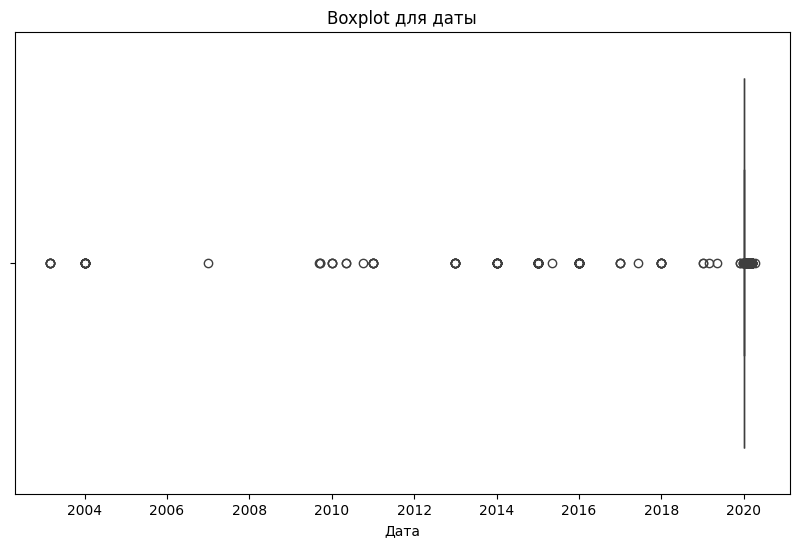

In [466]:
# Преобразуем в Pandas DataFrame
pandas_df = df.toPandas()

# Строим boxplot для столбца date_format
plt.figure(figsize=(10, 6))
sns.boxplot(x=pandas_df['date_format'])
plt.title('Boxplot для даты')
plt.xlabel('Дата')
plt.show()

Так как первое заболевание ковид зафиксировано в декабре 2019, то все даты до я бы считал выбросами.

Но для начала заполним пропуски самой популярной датой.

In [467]:
popular_date = (
    # фильтруем ненулевые значения
    df.filter(col("date_format").isNotNull())
    .groupBy("date_format")
    .count()
    .orderBy(desc("count"))
    .first()[0]  # извлекаем самую популярную дату
)

# Заполним пропуски самой популярной датой
df = df.withColumn(
    "date_format",
    when(col("date_format").isNull(), popular_date).otherwise(col("date_format"))
)

In [468]:
# Считаем количество строк до фильтрации
initial_count = df.count()

# Отфильтруем строки, где дата меньше 2019-12-01
df_filtered = df.filter(col("date_format") >= "2019-12-01")

# Считаем количество строк после фильтрации
final_count = df_filtered.count()

# Вычисляем, сколько строк было удалено
rows_deleted = initial_count - final_count

# Выведем информацию о количестве удалённых строк
print(f"Количество удалённых строк: {rows_deleted}")

# Просмотр результата
df_filtered.show()

df = df_filtered

Количество удалённых строк: 110
+---------+----+----+--------------------+----+-----------+
|patientid| age| sex|             finding|view|date_format|
+---------+----+----+--------------------+----+-----------+
|        2|  65|   M|Pneumonia/Viral/C...|  PA| 2020-01-22|
|        2|  65|   M|Pneumonia/Viral/C...|  PA| 2020-01-25|
|        2|  65|   M|Pneumonia/Viral/C...|  PA| 2020-01-27|
|        2|  65|   M|Pneumonia/Viral/C...|  PA| 2020-01-28|
|        4|  52|   F|Pneumonia/Viral/C...|  PA| 2020-01-25|
|        4|  52|   F|Pneumonia/Viral/C...|  PA| 2020-01-30|
|        6|NULL|NULL|Pneumonia/Viral/C...|  PA| 2020-01-06|
|        6|NULL|NULL|Pneumonia/Viral/C...|  PA| 2020-01-10|
|       11|  56|   M|Pneumonia/Viral/C...|  PA| 2020-01-01|
|       12|  42|   M|Pneumonia/Viral/C...|  PA| 2020-01-01|
|       13|  35|   M|Pneumonia/Viral/C...|  PA| 2020-01-19|
|       13|  35|   M|Pneumonia/Viral/C...|   L| 2020-01-19|
|       13|  35|   M|Pneumonia/Viral/C...|  PA| 2020-01-22|
|       

___
***Примечание: поменял местами пункты сначала Анализ качества данных, затем Предобработка***
### 2. Предобработка данных
- Заполнить пропуски в данных.
- Унифицировать диагнозы.
- Удалить дубликаты.

In [469]:
# Заполнение пропусков в столбце "age" средним значением
mean_age = df.select(mean("age")).first()[0]
df = df.fillna({"age": mean_age})

In [470]:
# Считаем пропорцию мужчин
male_ratio = (
    df.filter(col("sex").isNotNull())
    .groupBy("sex")
    .count()
    .filter(col("sex") == "M")
    .select((col("count") / df.filter(col("sex").isNotNull()).count()).alias("male_ratio"))
    .first()[0]
)

# Генерируем случайное число и заполняем пропуски по пропорции
df_filled = (
    df.withColumn("sex",
                  when(col("sex").isNull() & (rand() < male_ratio), "M")
                  .when(col("sex").isNull(), "F")
                  .otherwise(col("sex"))
                  )
)

#  Проверим распределение
df_filled.groupBy("sex").count().show()

+---+-----+
|sex|count|
+---+-----+
|  F|  296|
|  M|  544|
+---+-----+



Унификация диагнозов

In [471]:
# Определяем UDF функцию для унификации диагнозов
def unify_finding(finding):
    if finding is None:
        return "Unknown"
    
    finding_str = str(finding).strip()
    
    if "COVID-19" in finding_str:
        return "COVID-19"
    elif finding_str in ["No Finding", "todo", "Unknown"]:
        return "Unknown"
    elif "Tuberculosis" in finding_str:
        return "Tuberculosis"
    elif any(substring in finding_str for substring in [
        "Pneumonia/Bacterial", 
        "Pneumonia/Aspiration", 
        "Pneumonia/Lipoid", 
        "Pneumonia/Fungal", 
        "Pneumonia/Viral"
    ]):
        return "Pneumonia"
    else:
        return "Unknown"

# Регистрируем UDF
unify_finding_udf = udf(unify_finding, StringType())

# Применяем UDF к DataFrame
df = df_filled.withColumn("finding", unify_finding_udf(col("finding")))

# Проверим результат
df.select("finding").distinct().show(100, truncate=False)

+------------+
|finding     |
+------------+
|Tuberculosis|
|Unknown     |
|COVID-19    |
|Pneumonia   |
+------------+



Круговая диаграмма распределения диагнозов.

Дубликаты

In [472]:
# Удаляем полные дубликаты в DataFrame
df_no_duplicates = df.dropDuplicates()

# Количество удалённых дубликатов
rows_deleted = df.count()- df_no_duplicates.count()

# Выводим информацию
print(f"Количество удалённых дубликатов: {rows_deleted}")

Количество удалённых дубликатов: 235


In [473]:
df = df_no_duplicates

___
### 4. SQL-аналитика

- Запрос 1. Базовая статистика по диагнозам.

In [474]:
# Создаем временное представление (view) из очищенного датафрейма
df.createOrReplaceTempView("Tmp_table")

In [475]:
print("Запрос 1: Статистика по диагнозам")

spark.sql("""
SELECT
  finding AS `Диагноз`,
  COUNT(*) AS total_records,
  COUNT(DISTINCT patientid) AS unique_patients
FROM Tmp_table
GROUP BY finding
ORDER BY total_records DESC
""").show(truncate=False)

Запрос 1: Статистика по диагнозам
+------------+-------------+---------------+
|Диагноз     |total_records|unique_patients|
+------------+-------------+---------------+
|COVID-19    |443          |321            |
|Unknown     |97           |77             |
|Pneumonia   |48           |34             |
|Tuberculosis|17           |11             |
+------------+-------------+---------------+



Запрос 2. Распределение по полу и диагнозам

In [476]:
print("Анализ распределения диагнозов по полу")
spark.sql("""
    SELECT 
        sex AS `Пол`,
        finding AS `Диагноз`, 
        COUNT(*) AS `Количество`
    FROM 
        Tmp_table
    WHERE 
        finding IN ('COVID-19', 'Pneumonia', 'Tuberculosis', 'Unknown')
    GROUP BY 
        sex, 
        finding
    ORDER BY 
        finding,
        COUNT(*) DESC
""").show()

Анализ распределения диагнозов по полу
+---+------------+----------+
|Пол|     Диагноз|Количество|
+---+------------+----------+
|  M|    COVID-19|       292|
|  F|    COVID-19|       151|
|  M|   Pneumonia|        30|
|  F|   Pneumonia|        18|
|  M|Tuberculosis|        12|
|  F|Tuberculosis|         5|
|  M|     Unknown|        58|
|  F|     Unknown|        39|
+---+------------+----------+



Запрос 3. Оконная функция (топ-3 по возрасту в каждой группе диагнозов

In [477]:
print("Запрос 3: Оконная функция (топ-3 по возрасту в каждой группе диагнозов)")
spark.sql("""
    SELECT 
        patientid, 
        age AS `Возраст`, 
        finding AS `Диагноз`, 
        `Место`
    FROM (
        SELECT
            patientid, 
            age, 
            finding,
            ROW_NUMBER() OVER (PARTITION BY finding ORDER BY age DESC) as `Место`
        FROM 
            analysis_data
) T
    WHERE 
        `Место` <= 3
    ORDER BY 
        finding, 
        `Место`
""").show()

Запрос 3: Оконная функция (топ-3 по возрасту в каждой группе диагнозов)
+---------+-------+------------+-----+
|patientid|Возраст|     Диагноз|Место|
+---------+-------+------------+-----+
|     326b|     94|    COVID-19|    1|
|     324b|     93|    COVID-19|    2|
|      200|     88|    COVID-19|    3|
|       91|     80|   Pneumonia|    1|
|      340|     80|   Pneumonia|    2|
|      340|     80|   Pneumonia|    3|
|      421|     78|Tuberculosis|    1|
|      453|     70|Tuberculosis|    2|
|      456|     58|Tuberculosis|    3|
|      460|     90|     Unknown|    1|
|      460|     90|     Unknown|    2|
|      454|     78|     Unknown|    3|
+---------+-------+------------+-----+



Запрос 4. Анализ временных трендов по датам исследований.

In [478]:
print("Запрос 4. Анализ временных трендов по датам исследований.")
spark.sql("""
    SELECT
        finding AS `Диагноз`,
        YEAR(date_format) AS `Год`,
        MONTH(date_format) AS `Месяц`,
        COUNT(*) AS `Количество исследований`
    FROM Tmp_table
    GROUP BY
        finding,
        YEAR(date_format),
        MONTH(date_format)
    ORDER BY
        finding,
        `Год`,
        `Месяц`
""").show(100, truncate=False)

Запрос 4. Анализ временных трендов по датам исследований.
+------------+----+-----+-----------------------+
|Диагноз     |Год |Месяц|Количество исследований|
+------------+----+-----+-----------------------+
|COVID-19    |2019|12   |4                      |
|COVID-19    |2020|1    |391                    |
|COVID-19    |2020|2    |17                     |
|COVID-19    |2020|3    |30                     |
|COVID-19    |2020|4    |1                      |
|Pneumonia   |2020|1    |44                     |
|Pneumonia   |2020|3    |4                      |
|Tuberculosis|2020|1    |17                     |
|Unknown     |2020|1    |95                     |
|Unknown     |2020|3    |2                      |
+------------+----+-----+-----------------------+



In [479]:
print("Запрос 5: Статистика по проекциям снимков и их связи с диагнозами")
spark.sql("""
    SELECT 
        view AS `Проекция`, 
        finding AS `Диагноз`, 
        COUNT(*) AS `Количество`
    FROM 
        Tmp_table
    WHERE 
        view != 'Unknown' 
        AND finding IN ('COVID-19', 'Pneumonia', 'Normal')
    GROUP BY 
        `Проекция`, 
        `Диагноз`
    ORDER BY 
        `Диагноз`, 
        `Количество` DESC
""").show()

Запрос 5: Статистика по проекциям снимков и их связи с диагнозами
+---------+---------+----------+
| Проекция|  Диагноз|Количество|
+---------+---------+----------+
|       PA| COVID-19|       159|
|       AP| COVID-19|       107|
|AP Supine| COVID-19|        95|
|    Axial| COVID-19|        45|
|        L| COVID-19|        25|
|  Coronal| COVID-19|        12|
|       AP|Pneumonia|        19|
|       PA|Pneumonia|        16|
|        L|Pneumonia|         9|
|AP Supine|Pneumonia|         3|
| AP Erect|Pneumonia|         1|
+---------+---------+----------+



___
### 5. Обработка в PySpark
Использование UDF:
- Реализация пользовательской функции для категоризации возраста.

In [480]:
#  Определяем функцию для категоризации возраста
def categorize_age(age):
    if 18 <= age <= 29:
        return 'Молодой возраст'
    elif 30 <= age <= 59:
        return 'Средний возраст'
    elif 60 <= age <= 79:
        return 'Пожилой возраст'
    elif 80 <= age:
        return 'Очень пожилой возраст'


# Регистрируем функцию как UDF
categorize_age_udf = udf(categorize_age, StringType())

#  Применяем UDF к DataFrame
df_with_age_category = df.withColumn(
    "age_category", categorize_age_udf(df["age"]))

# Показываем результат
df_with_age_category.show()

+---------+---+---+---------+---------+-----------+--------------------+
|patientid|age|sex|  finding|     view|date_format|        age_category|
+---------+---+---+---------+---------+-----------+--------------------+
|       35| 43|  M| COVID-19|    Axial| 2020-03-04|     Средний возраст|
|      321| 75|  F| COVID-19|       AP| 2020-01-01|     Пожилой возраст|
|      334| 52|  M| COVID-19|       PA| 2020-01-01|     Средний возраст|
|      356| 55|  M| COVID-19|AP Supine| 2020-01-01|     Средний возраст|
|      397| 55|  M|  Unknown|       PA| 2020-01-01|     Средний возраст|
|      466| 70|  F|  Unknown|        L| 2020-01-01|     Пожилой возраст|
|       20| 53|  M| COVID-19|        L| 2020-01-01|     Средний возраст|
|       51| 47|  M| COVID-19|        L| 2020-03-10|     Средний возраст|
|      207| 62|  M| COVID-19|  Coronal| 2020-01-01|     Пожилой возраст|
|     313b| 75|  M|  Unknown|       AP| 2020-01-01|     Пожилой возраст|
|      314| 21|  M| COVID-19|       AP| 2020-01-01|

- Унификация диагнозов. **Уже выполнена с помощью UDF** выше

- Сохранение результатов в оптимизированном формате.

In [481]:
# Сохраняем результат в Parquet
df.write.mode("overwrite").parquet("parquet")

___
### 6. Визуализация
- Круговая диаграмма распределения диагнозов.

In [482]:
# Читаем Parquet в PySpark
df = spark.read.parquet("parquet")
df.show(5)

+---------+---+---+--------+---------+-----------+
|patientid|age|sex| finding|     view|date_format|
+---------+---+---+--------+---------+-----------+
|       35| 43|  M|COVID-19|    Axial| 2020-03-04|
|      321| 75|  F|COVID-19|       AP| 2020-01-01|
|      334| 52|  M|COVID-19|       PA| 2020-01-01|
|      356| 55|  M|COVID-19|AP Supine| 2020-01-01|
|      397| 55|  M| Unknown|       PA| 2020-01-01|
+---------+---+---+--------+---------+-----------+
only showing top 5 rows


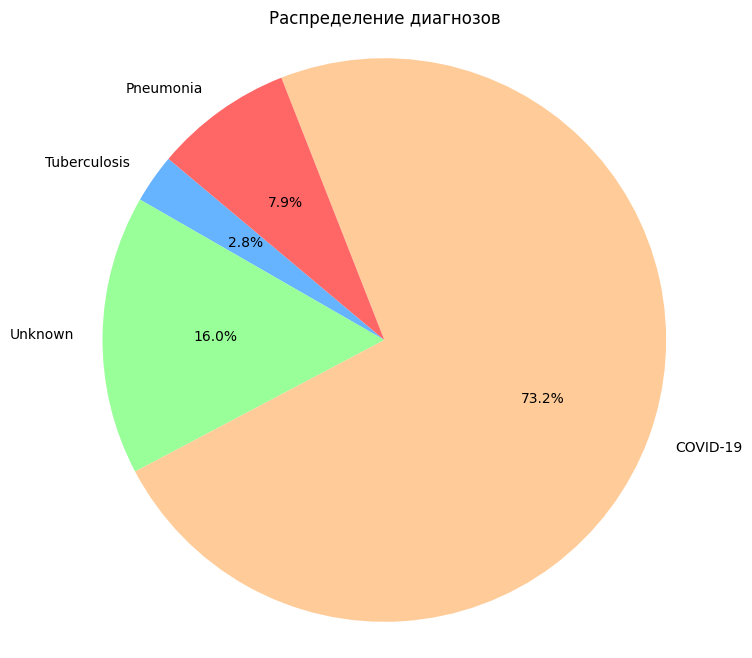

In [483]:
# Подсчитываем количество каждого диагноза
diagnosis_counts = df.groupBy("finding").count().toPandas()

# Строим круговую диаграмму
plt.figure(figsize=(8, 8))
plt.pie(diagnosis_counts['count'], labels=diagnosis_counts['finding'], autopct='%1.1f%%',
        startangle=140, colors=['#66b3ff', '#99ff99', '#ffcc99', '#ff6666'])
plt.title('Распределение диагнозов')
plt.axis('equal')  # Чтобы круг был кругом
plt.show()

- Столбчатая диаграмма по возрастным группам.

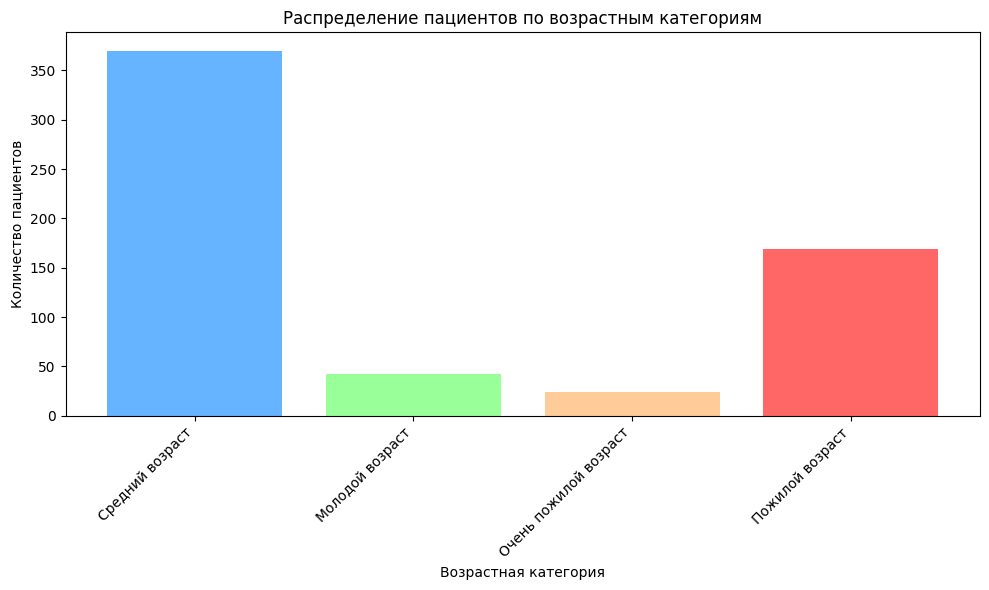

In [484]:
# Сначала добавим категорию возраста в DataFrame
df_with_age_category = df.withColumn(
    "age_category", categorize_age_udf(df["age"]))

# Подсчитаем количество пациентов в каждой возрастной группе
age_category_counts = df_with_age_category.groupBy(
    "age_category").count().toPandas()

# Строим столбчатую диаграмму
plt.figure(figsize=(10, 6))
plt.bar(age_category_counts['age_category'], age_category_counts['count'], color=[
        '#66b3ff', '#99ff99', '#ffcc99', '#ff6666'])
plt.xlabel('Возрастная категория')
plt.ylabel('Количество пациентов')
plt.title('Распределение пациентов по возрастным категориям')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- График временных трендов исследований.

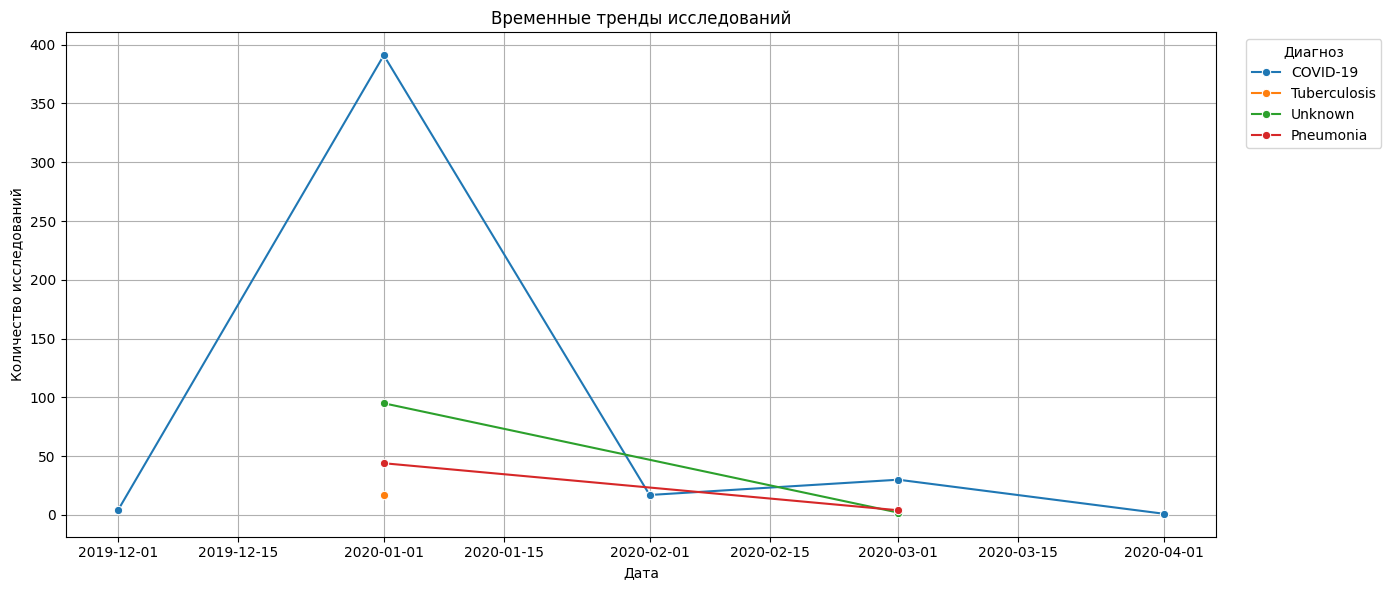

In [485]:
# Преобразуем дату в формат datetime
df_with_age_category = df_with_age_category.withColumn(
    "date_format", df_with_age_category["date_format"].cast("timestamp"))

# Извлекаем год и месяц
df_with_age_category = df_with_age_category.withColumn("year", year(df_with_age_category["date_format"]))\
    .withColumn("month", month(df_with_age_category["date_format"]))

# Группируем по году, месяцу и диагнозу, и считаем количество исследований
monthly_counts = df_with_age_category.groupBy(
    "year", "month", "finding").count().toPandas()

# Создаем новый столбец для отображения даты в формате Год-Месяц
monthly_counts['Дата'] = pd.to_datetime(
    monthly_counts[['year', 'month']].assign(day=1))

# Строим график с разделением по диагнозам
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_counts, x='Дата', y='count',
             hue='finding', marker='o', palette='tab10')

plt.title('Временные тренды исследований')
plt.xlabel('Дата')
plt.ylabel('Количество исследований')
plt.legend(title='Диагноз', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Виден перекос на 2020-01-01 так как неизвестные даты перенеслись на данный временной отрезок.

- Heatmap распределения диагнозов по проекциям снимков.

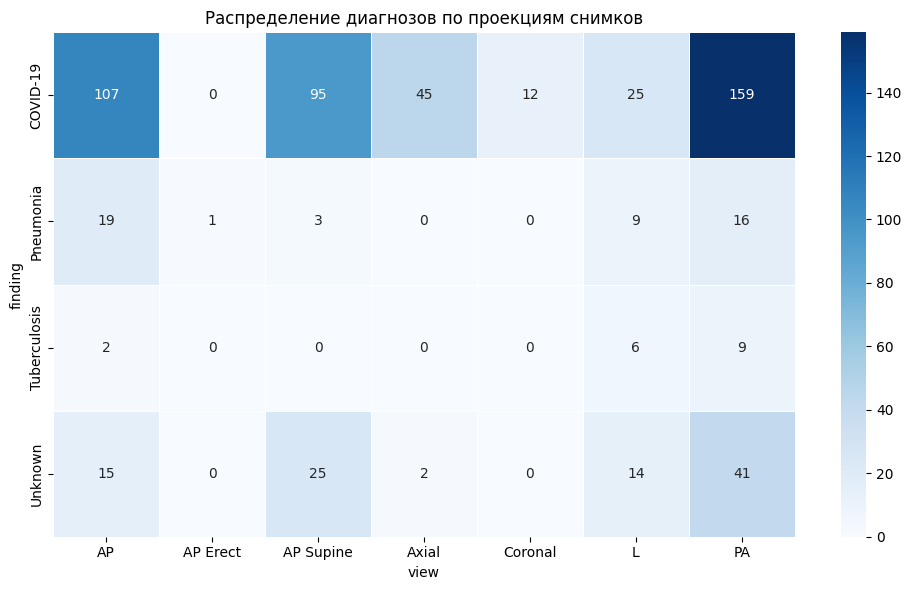

In [486]:
# Группируем по диагнозам и проекциям снимков, затем подсчитываем количество
heatmap_data = df_with_age_category.groupBy(
    "finding", "view").count().toPandas()

# Преобразуем данные в широкий формат для тепловой карты
heatmap_data_pivot = heatmap_data.pivot(
    index="finding", columns="view", values="count")

heatmap_data_pivot = heatmap_data_pivot.fillna(0)

# Строим тепловую карту
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data_pivot, annot=True,
            cmap='Blues', fmt='.0f', linewidths=0.5)
plt.title('Распределение диагнозов по проекциям снимков')
plt.tight_layout()
plt.show()

### Выводы: